In [1]:
"""
Earnings Implied Volatility - Week 1: Enhanced Data Pipeline
MFE Independent Study - UC Berkeley Haas

Enhanced version with volatility smile analysis, earnings event study, 
term structure analysis, and removal of synthetic data creation.

Requirements:
- WRDS account and Python library (pip install wrds)
- pandas, numpy, matplotlib, seaborn, scipy
- Access to OptionMetrics and Compustat databases
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import wrds

class EarningsIVDataPipeline:
    """
    Enhanced data pipeline for earnings implied volatility analysis using WRDS data
    """
    
    def __init__(self, db_connection):
        """
        Initialize with existing WRDS connection
        
        Args:
            db_connection: Existing WRDS database connection
        """
        self.db = db_connection
        self.data = {}
        self.available_tables = None
        
    def setup_optionm_tables(self):
        """
        Get available OptionMetrics tables
        """
        if self.available_tables is None:
            tables_df = self.db.raw_sql("""
                SELECT table_name
                FROM information_schema.tables
                WHERE table_schema = 'optionm'
                ORDER BY table_name
            """)
            self.available_tables = set(tables_df['table_name'].str.lower())
        return self.available_tables
    
    def build_optionm_query(self, table_base, start_date, end_date, fields, secids=None):
        """
        Build OptionMetrics query using your existing query builder logic
        """
        table_base = table_base.lower()
        
        # Match all tables starting with the given base (e.g. opprcd)
        matching_tables = [t for t in self.available_tables if t.startswith(table_base)]
        if not matching_tables:
            return f"Table '{table_base}' not found in OptionMetrics."
        
        # SECID filter
        secid_filter = ""
        if secids is not None:
            if isinstance(secids, (list, tuple, set)):
                secid_list = ", ".join(str(s) for s in secids)
                secid_filter = f"AND secid IN ({secid_list})"
            else:
                secid_filter = f"AND secid = {secids}"
        
        # Determine year range
        years = list(range(pd.to_datetime(start_date).year, pd.to_datetime(end_date).year + 1))
        
        # Case: non-suffixed (single) table (e.g., 'securd1')
        if table_base in matching_tables:
            return f"""
    SELECT {', '.join(fields)}
    FROM optionm.{table_base}
    WHERE date BETWEEN '{start_date}' AND '{end_date}'
    {secid_filter}
            """.strip()
        
        # Case: year-suffixed tables (e.g., opprcd2014, hvold2015, etc.)
        union_queries = []
        for year in years:
            table_year = f"{table_base}{year}"
            if table_year in matching_tables:
                query = f"""
    SELECT {', '.join(fields)}
    FROM optionm.{table_year}
    WHERE date BETWEEN '{start_date}' AND '{end_date}'
    {secid_filter}
    """.strip()
                union_queries.append(query)
        
        if not union_queries:
            return f"No available year-specific tables for '{table_base}' in range {years}."
        
        return "\nUNION ALL\n".join(union_queries)
    
    def build_rdq_query_from_tickers(self, ticker_list, start_date, end_date):
        """
        Build SQL query to fetch earnings report dates (rdq) for a list of tickers.
        """
        if not ticker_list:
            raise ValueError("You must provide at least one ticker.")
        
        # Format tickers for SQL IN clause
        formatted_tickers = ', '.join([f"'{ticker}'" for ticker in ticker_list])
        
        query = f"""
        SELECT cusip,
               tic as ticker,
               datadate,
               rdq as earnings_date,
               fyearq,
               fqtr
        FROM comp.fundq
        WHERE tic IN ({formatted_tickers})
          AND rdq BETWEEN '{start_date}' AND '{end_date}'
          AND rdq IS NOT NULL
        ORDER BY tic, rdq;
        """
        return query
    
    def build_secprd_query(self, secid_list, start_date, end_date):
        """
        Build SQL query to fetch daily stock data from optionm.secprd for a list of SECIDs.
        """
        if not secid_list:
            raise ValueError("SECID list is empty.")
        
        # Format SECIDs as numeric values, no quotes
        formatted_secids = ', '.join([str(int(secid)) for secid in secid_list])
        
        query = f"""
        SELECT *
        FROM optionm.secprd
        WHERE secid IN ({formatted_secids})
          AND date BETWEEN '{start_date}' AND '{end_date}'
        ORDER BY secid, date;
        """
        return query
    
    def get_securities_info(self, ticker_list):
        """
        Get security information from OptionMetrics securd1 table
        """
        print("Fetching security information from OptionMetrics...")
        
        # Format tickers for SQL IN clause
        formatted_tickers = ', '.join([f"'{ticker}'" for ticker in ticker_list])
        
        query = f"""
        SELECT DISTINCT *
        FROM optionm.securd1
        WHERE ticker IN ({formatted_tickers})
          AND exchange_d != 0
        ORDER BY ticker
        """
        
        self.data['securities'] = self.db.raw_sql(query)
        print(f"Retrieved {len(self.data['securities'])} securities")
        
        return self.data['securities']
    
    def get_earnings_dates(self, ticker_list, start_date='2023-01-01', end_date='2024-12-31'):
        """
        Fetch earnings announcement dates using Compustat
        """
        print("Fetching earnings announcement dates from Compustat...")
        
        query = self.build_rdq_query_from_tickers(ticker_list, start_date, end_date)
        
        try:
            self.data['earnings'] = self.db.raw_sql(query)
            print(f"Retrieved {len(self.data['earnings'])} earnings announcements")
            return self.data['earnings']
        except Exception as e:
            print(f"Error fetching earnings data: {e}")
            return None
    
    def get_option_data(self, secid_list, start_date='2023-01-01', end_date='2024-12-31'):
        """
        Fetch option data from OptionMetrics using secids - NO SYNTHETIC DATA
        """
        print("Fetching option data from OptionMetrics...")
        
        # Setup available tables
        self.setup_optionm_tables()
        
        # Define fields to select - using common OptionMetrics field names
        fields = [
            'date', 'secid', 'exdate', 'strike_price', 'cp_flag',
            'best_bid', 'best_offer', 'open_interest',
            'impl_volatility', 'delta', 'gamma', 'theta', 'vega', 'volume'
        ]
        
        # Build query using your query builder
        query = self.build_optionm_query('opprcd', start_date, end_date, fields, secid_list)
        
        if "not found" in query or "No available" in query:
            print(f"Query build failed: {query}")
            return None
        
        try:
            print("Executing options query...")
            self.data['options'] = self.db.raw_sql(query)
            
            # Debug: Print column names to see what's available
            print(f"Available columns in options data: {list(self.data['options'].columns)}")
            
            # Check for volume column variations
            volume_field_candidates = ['volume', 'vol', 'contract_volume', 'opt_volume']
            volume_col = None
            for col_candidate in volume_field_candidates:
                if col_candidate in self.data['options'].columns:
                    volume_col = col_candidate
                    break
            
            if volume_col and volume_col != 'volume':
                print(f"Found volume column: {volume_col}, renaming to 'volume'")
                self.data['options']['volume'] = self.data['options'][volume_col]
            
            print(f"Retrieved {len(self.data['options'])} option records")
            return self.data['options']
            
        except Exception as e:
            print(f"Error fetching options data: {e}")
            print("Attempting to query with minimal fields...")
            
            # Fallback: try with minimal fields - NO SYNTHETIC DATA
            minimal_fields = ['date', 'secid', 'exdate', 'strike_price', 'cp_flag', 
                            'best_bid', 'best_offer', 'impl_volatility']
            
            query = self.build_optionm_query('opprcd', start_date, end_date, minimal_fields, secid_list)
            
            try:
                self.data['options'] = self.db.raw_sql(query)
                print(f"Retrieved {len(self.data['options'])} option records with minimal fields")
                print("Warning: Limited fields available - some analyses may not be possible")
                return self.data['options']
            except Exception as e2:
                print(f"Fallback also failed: {e2}")
                return None
    
    def get_stock_prices(self, secid_list, start_date='2023-01-01', end_date='2024-12-31'):
        """
        Get underlying stock prices from OptionMetrics secprd
        """
        print("Fetching stock prices from OptionMetrics...")
        
        query = self.build_secprd_query(secid_list, start_date, end_date)
        
        try:
            self.data['stock_prices'] = self.db.raw_sql(query)
            print(f"Retrieved {len(self.data['stock_prices'])} stock price records")
            return self.data['stock_prices']
        except Exception as e:
            print(f"Error fetching stock prices: {e}")
            return None
    
    def merge_securities_earnings(self):
        """
        Merge securities info with earnings data using ticker matching
        """
        if 'securities' not in self.data or 'earnings' not in self.data:
            print("Need both securities and earnings data")
            return None
        
        # Merge on ticker
        merged = self.data['earnings'].merge(
            self.data['securities'][['secid', 'ticker', 'cusip', 'issuer']], 
            on='ticker', 
            how='inner'
        )
        
        self.data['earnings_securities'] = merged
        print(f"Merged {len(merged)} earnings-securities records")
        return merged
    
    def calculate_option_metrics(self):
        """
        Calculate additional option metrics - ONLY WITH REAL DATA
        """
        if 'options' not in self.data:
            raise ValueError("Options data not loaded. Run get_option_data() first.")
        
        df = self.data['options'].copy()
        
        # Convert dates to datetime objects
        df['date'] = pd.to_datetime(df['date'])
        df['exdate'] = pd.to_datetime(df['exdate'])
        
        # Calculate time to expiration in days
        df['tte'] = (df['exdate'] - df['date']).dt.days
        
        # Initialize underlying_price columns
        df['underlying_price'] = np.nan

        # Merge with stock prices to get underlying prices
        if 'stock_prices' in self.data and not self.data['stock_prices'].empty:
            stock_df = self.data['stock_prices'].copy()
            stock_df['date'] = pd.to_datetime(stock_df['date'])
            
            # Rename columns in stock_df BEFORE merging to avoid suffix issues
            stock_df = stock_df.rename(columns={'close': 'underlying_price'})
            
            # Only merge if stock_df has the necessary columns after rename
            if 'underlying_price' in stock_df.columns:
                df = df.merge(stock_df[['date', 'secid', 'underlying_price']], 
                              on=['date', 'secid'], 
                              how='left',
                              suffixes=('', '_stock')) 
            else:
                print("Warning: stock_prices DataFrame is missing 'close' column. Cannot merge underlying price.")
        else:
            print("Warning: No stock prices data available. Cannot calculate proper moneyness.")
            
        # Calculate mid_price
        if 'best_bid' in df.columns and 'best_offer' in df.columns:
            df['mid_price'] = (df['best_bid'] + df['best_offer']) / 2
        
        # Only fill missing underlying prices with mid_price if both exist
        if 'mid_price' in df.columns:
            df['underlying_price'] = df['underlying_price'].fillna(df['mid_price'])

        # Calculate moneyness: Keep your original calculation
        df['moneyness'] = df['strike_price'] / 100000.0
        
        # Calculate bid-ask spread only if both bid and offer exist
        if 'best_bid' in df.columns and 'best_offer' in df.columns:
            df['bid_ask_spread'] = np.where(
                df['best_bid'] > 0, 
                (df['best_offer'] - df['best_bid']) / df['best_bid'], 
                np.nan 
            )
            df['bid_ask_spread'] = df['bid_ask_spread'].clip(lower=0) 
        
        # Log moneyness - only if moneyness is valid
        if 'moneyness' in df.columns:
            df['log_moneyness'] = np.log(df['moneyness'].clip(lower=0.01)) 
        
        self.data['options_enhanced'] = df
        print(f"Enhanced {len(df)} option records with calculated metrics")
        
        return df
    
    def apply_data_filters(self, min_volume=10, max_bid_ask_spread=0.5, 
                           tte_range=(7, 60), moneyness_range=(0.8, 1.2)):
        """
        Apply data quality filters - ONLY filter on available real data
        """
        if 'options_enhanced' not in self.data:
            self.calculate_option_metrics()
        
        df = self.data['options_enhanced'].copy()
        initial_count = len(df)
        
        print(f"Applying filters to {initial_count:,} records...")
        print(f"Available columns: {list(df.columns)}")
        
        # Apply filters conditionally based on available columns
        
        if 'volume' in df.columns:
            df_before = len(df)
            df = df[df['volume'].notna() & (df['volume'] >= min_volume)]
            print(f"  After Volume filter (>= {min_volume}): {len(df):,} records ({len(df)/df_before:.1%} retained)")
        
        if 'bid_ask_spread' in df.columns:
            df_before = len(df)
            df = df[df['bid_ask_spread'].notna() & (df['bid_ask_spread'] <= max_bid_ask_spread)]
            print(f"  After Bid-ask spread filter (<= {max_bid_ask_spread}): {len(df):,} records ({len(df)/df_before:.1%} retained)")
        
        if 'tte' in df.columns:
            df_before = len(df)
            df = df[(df['tte'] >= tte_range[0]) & (df['tte'] <= tte_range[1])]
            print(f"  After TTE filter ({tte_range[0]} <= tte <= {tte_range[1]}): {len(df):,} records ({len(df)/df_before:.1%} retained)")
        
        if 'moneyness' in df.columns:
            df_before = len(df)
            df = df[(df['moneyness'] >= moneyness_range[0]) & (df['moneyness'] <= moneyness_range[1])]
            print(f"  After Moneyness filter ({moneyness_range[0]} <= moneyness <= {moneyness_range[1]}): {len(df):,} records ({len(df)/df_before:.1%} retained)")
        
        # Only filter on real data columns
        real_data_filters = [
            ('vega', lambda x: x > 0),
            ('best_bid', lambda x: x > 0),
            ('best_offer', lambda x: x > 0),
            ('impl_volatility', lambda x: x > 0)
        ]
        
        for col_name, filter_func in real_data_filters:
            if col_name in df.columns:
                df_before = len(df)
                df = df[df[col_name].notna() & df[col_name].apply(filter_func)]
                print(f"  After {col_name} filter: {len(df):,} records ({len(df)/df_before:.1%} retained)")
        
        filtered_count = len(df)
        print(f"Filtered from {initial_count:,} to {filtered_count:,} records "
              f"({filtered_count/initial_count:.1%} retention)")
        
        self.data['options_filtered'] = df
        
        return df
    
    def merge_earnings_options(self, event_window_days=30):
        """
        Merge earnings dates with option data using secid
        """
        if 'earnings_securities' not in self.data or 'options_filtered' not in self.data:
            print("Need both earnings_securities and options_filtered data")
            return None
        
        earnings = self.data['earnings_securities'].copy()
        options = self.data['options_filtered'].copy()
        
        # Convert dates
        earnings['earnings_date'] = pd.to_datetime(earnings['earnings_date'])
        options['date'] = pd.to_datetime(options['date'])
        
        # Merge on secid
        merged_data = []
        
        for _, earning in earnings.iterrows():
            secid = earning['secid']
            earnings_date = earning['earnings_date']
            
            # Get options data within event window
            secid_options = options[
                (options['secid'] == secid) &
                (options['date'] >= earnings_date - timedelta(days=event_window_days)) &
                (options['date'] <= earnings_date)
            ].copy()
            
            if len(secid_options) > 0:
                secid_options['earnings_date'] = earnings_date
                secid_options['days_to_earnings'] = (earnings_date - secid_options['date']).dt.days
                secid_options['ticker'] = earning['ticker']
                merged_data.append(secid_options)
        
        if merged_data:
            self.data['earnings_options'] = pd.concat(merged_data, ignore_index=True)
            print(f"Merged dataset contains {len(self.data['earnings_options'])} records")
        else:
            print("No matching earnings-options data found")
            
        return self.data.get('earnings_options')
    
    def analyze_volatility_smile(self):
        """
        NEW: Analyze volatility smile patterns across different time to expiration
        """
        if 'earnings_options' not in self.data:
            print("No earnings-options data available for smile analysis")
            return
        
        df = self.data['earnings_options'].copy()
        
        # Create TTE bins
        df['tte_bin'] = pd.cut(df['tte'], 
                              bins=[0, 14, 30, 45, 60], 
                              labels=['0-14d', '14-30d', '30-45d', '45-60d'])
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Volatility Smile Analysis by Time to Expiration', fontsize=16)
        
        colors = ['blue', 'green', 'red', 'orange']
        tte_bins = df['tte_bin'].dropna().unique()
        
        for i, (ax, tte_bin) in enumerate(zip(axes.flat, tte_bins)):
            if pd.isna(tte_bin):
                continue
                
            subset = df[df['tte_bin'] == tte_bin]
            
            if len(subset) > 0 and 'moneyness' in subset.columns:
                # Group by moneyness bins and calculate mean IV
                subset['moneyness_bin'] = pd.cut(subset['moneyness'], bins=20)
                smile_data = subset.groupby('moneyness_bin')['impl_volatility'].agg(['mean', 'count']).reset_index()
                smile_data = smile_data[smile_data['count'] >= 5]  # Minimum observations
                
                if len(smile_data) > 0:
                    moneyness_centers = smile_data['moneyness_bin'].apply(lambda x: x.mid)
                    ax.plot(moneyness_centers, smile_data['mean'], 'o-', color=colors[i % len(colors)])
                    ax.set_xlabel('Moneyness')
                    ax.set_ylabel('Implied Volatility')
                    ax.set_title(f'TTE: {tte_bin}')
                    ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Summary statistics
        print("\n" + "="*50)
        print("VOLATILITY SMILE ANALYSIS")
        print("="*50)
        
        smile_stats = df.groupby(['tte_bin'])['impl_volatility'].agg([
            'count', 'mean', 'std', 'min', 'max'
        ]).round(4)
        
        print("\nImplied Volatility Statistics by TTE:")
        print(smile_stats)
        
        return smile_stats
    
    def earnings_event_study(self, pre_earnings_days=21, post_earnings_days=5):
        """
        NEW: Analyze pre vs post earnings volatility patterns
        """
        if 'earnings_securities' not in self.data or 'options_filtered' not in self.data:
            print("Need both earnings_securities and options_filtered data for event study")
            return None
        
        earnings = self.data['earnings_securities'].copy()
        options = self.data['options_filtered'].copy()
        
        # Convert dates
        earnings['earnings_date'] = pd.to_datetime(earnings['earnings_date'])
        options['date'] = pd.to_datetime(options['date'])
        
        event_study_data = []
        
        for _, earning in earnings.iterrows():
            secid = earning['secid']
            earnings_date = earning['earnings_date']
            
            # Get pre-earnings options data
            pre_options = options[
                (options['secid'] == secid) &
                (options['date'] >= earnings_date - timedelta(days=pre_earnings_days)) &
                (options['date'] < earnings_date)
            ].copy()
            
            # Get post-earnings options data
            post_options = options[
                (options['secid'] == secid) &
                (options['date'] > earnings_date) &
                (options['date'] <= earnings_date + timedelta(days=post_earnings_days))
            ].copy()
            
            # Mark periods
            pre_options['period'] = 'pre_earnings'
            post_options['period'] = 'post_earnings'
            
            # Add earnings info
            for df in [pre_options, post_options]:
                if len(df) > 0:
                    df['earnings_date'] = earnings_date
                    df['ticker'] = earning['ticker']
                    df['days_to_earnings'] = (earnings_date - df['date']).dt.days
            
            event_study_data.extend([pre_options, post_options])
        
        if event_study_data:
            # Filter out empty dataframes
            event_study_data = [df for df in event_study_data if len(df) > 0]
            
            if event_study_data:
                event_df = pd.concat(event_study_data, ignore_index=True)
                
                # Analyze volatility changes
                fig, axes = plt.subplots(1, 2, figsize=(15, 6))
                
                # Box plot of IV by period
                if 'period' in event_df.columns:
                    event_df.boxplot(column='impl_volatility', by='period', ax=axes[0])
                    axes[0].set_title('Implied Volatility: Pre vs Post Earnings')
                    axes[0].set_xlabel('Period')
                    axes[0].set_ylabel('Implied Volatility')
                
                # Time series of average IV
                daily_iv = event_df.groupby(['days_to_earnings', 'period'])['impl_volatility'].mean().reset_index()
                
                for period in daily_iv['period'].unique():
                    period_data = daily_iv[daily_iv['period'] == period]
                    axes[1].plot(period_data['days_to_earnings'], period_data['impl_volatility'], 
                               'o-', label=period)
                
                axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Earnings Date')
                axes[1].set_xlabel('Days to Earnings')
                axes[1].set_ylabel('Average Implied Volatility')
                axes[1].set_title('IV Evolution Around Earnings')
                axes[1].legend()
                axes[1].grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
                
                # Statistical analysis
                pre_iv = event_df[event_df['period'] == 'pre_earnings']['impl_volatility'].dropna()
                post_iv = event_df[event_df['period'] == 'post_earnings']['impl_volatility'].dropna()
                
                if len(pre_iv) > 0 and len(post_iv) > 0:
                    t_stat, p_value = stats.ttest_ind(pre_iv, post_iv)
                    
                    print("\n" + "="*50)
                    print("EARNINGS EVENT STUDY ANALYSIS")
                    print("="*50)
                    print(f"Pre-earnings IV: Mean = {pre_iv.mean():.4f}, Std = {pre_iv.std():.4f}, N = {len(pre_iv)}")
                    print(f"Post-earnings IV: Mean = {post_iv.mean():.4f}, Std = {post_iv.std():.4f}, N = {len(post_iv)}")
                    print(f"T-test: t-stat = {t_stat:.4f}, p-value = {p_value:.4f}")
                    
                    if p_value < 0.05:
                        print("*** Significant difference in pre vs post earnings IV ***")
                    else:
                        print("No significant difference in pre vs post earnings IV")
                
                self.data['event_study'] = event_df
                return event_df
        
        print("No sufficient data for earnings event study")
        return None
    
    def analyze_term_structure(self):
        """
        NEW: Analyze implied volatility term structure
        """
        if 'earnings_options' not in self.data:
            print("No earnings-options data available for term structure analysis")
            return
        
        df = self.data['earnings_options'].copy()
        
        # Focus on ATM options for term structure
        if 'moneyness' in df.columns:
            atm_options = df[
                (df['moneyness'] >= 0.8) & 
                (df['moneyness'] <= 1.2)
            ].copy()
        else:
            atm_options = df.copy()
        
        if len(atm_options) == 0:
            print("No ATM options available for term structure analysis")
            return
        
        # Group by TTE and calculate average IV
        term_structure = atm_options.groupby('tte')['impl_volatility'].agg([
            'mean', 'std', 'count'
        ]).reset_index()
        
        # Filter for sufficient observations
        term_structure = term_structure[term_structure['count'] >= 5]
        
        if len(term_structure) == 0:
            print("Insufficient data for term structure analysis")
            return
        
        # Plot term structure
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Term structure plot
        axes[0].errorbar(term_structure['tte'], term_structure['mean'], 
                        yerr=term_structure['std'], 
                        marker='o', capsize=5, capthick=2)
        axes[0].set_xlabel('Time to Expiration (Days)')
        axes[0].set_ylabel('Implied Volatility')
        axes[0].set_title('Implied Volatility Term Structure (ATM Options)')
        axes[0].grid(True, alpha=0.3)
        
        # Scatter plot with trend line
        axes[1].scatter(atm_options['tte'], atm_options['impl_volatility'], alpha=0.5)
        
        # Fit polynomial trend
        if len(term_structure) > 2:
            z = np.polyfit(term_structure['tte'], term_structure['mean'], 2)
            p = np.poly1d(z)
            x_trend = np.linspace(term_structure['tte'].min(), term_structure['tte'].max(), 100)
            axes[1].plot(x_trend, p(x_trend), "r--", alpha=0.8, label='Quadratic Fit')
            axes[1].legend()
        
        axes[1].set_xlabel('Time to Expiration (Days)')
        axes[1].set_ylabel('Implied Volatility')
        axes[1].set_title('IV vs TTE Scatter with Trend')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*50)
        print("IMPLIED VOLATILITY TERM STRUCTURE")
        print("="*50)
        print("\nTerm Structure Summary:")
        print(term_structure[['tte', 'mean', 'std', 'count']].round(4))
        
        # Calculate term structure slope
        if len(term_structure) > 1:
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                term_structure['tte'], term_structure['mean']
            )
            
            print(f"\nTerm Structure Linear Regression:")
            print(f"Slope: {slope:.6f} (IV per day)")
            print(f"R-squared: {r_value**2:.4f}")
            print(f"P-value: {p_value:.4f}")
            
            if slope > 0:
                print("*** Upward sloping term structure (normal backwardation) ***")
            else:
                print("*** Downward sloping term structure (contango) ***")
        
        self.data['term_structure'] = term_structure
        return term_structure
    
    def generate_summary_report(self):
        """
        Generate comprehensive summary report
        """
        print("\n" + "="*70)
        print("EARNINGS IMPLIED VOLATILITY ANALYSIS - SUMMARY REPORT")
        print("="*70)
        
        # Data availability summary
        print("\n📊 DATA AVAILABILITY:")
        print("-" * 30)
        for key, value in self.data.items():
            if isinstance(value, pd.DataFrame):
                print(f"{key:20}: {len(value):,} records")
            else:
                print(f"{key:20}: {type(value)}")
        
        # Securities summary
        if 'securities' in self.data:
            print(f"\n🏢 SECURITIES ANALYZED:")
            print("-" * 30)
            securities_summary = self.data['securities'].groupby('ticker').agg({
                'secid': 'count',
                'issuer': 'first'
            }).reset_index()
            print(securities_summary.to_string(index=False))
        
        # Earnings summary
        if 'earnings' in self.data:
            print(f"\n📈 EARNINGS ANNOUNCEMENTS:")
            print("-" * 30)
            earnings_summary = self.data['earnings'].groupby('ticker')['earnings_date'].agg([
                'count', 'min', 'max'
            ]).reset_index()
            print(earnings_summary.to_string(index=False))
        
        # Options data quality
        if 'options_filtered' in self.data:
            print(f"\n⚙️ OPTIONS DATA QUALITY:")
            print("-" * 30)
            options_df = self.data['options_filtered']
            
            print(f"Total option contracts: {len(options_df):,}")
            print(f"Unique securities: {options_df['secid'].nunique():,}")
            print(f"Date range: {options_df['date'].min()} to {options_df['date'].max()}")
            
            if 'cp_flag' in options_df.columns:
                print("\nCall vs Put distribution:")
                cp_counts = options_df['cp_flag'].value_counts()
                for flag, count in cp_counts.items():
                    option_type = 'Call' if flag == 'C' else 'Put' if flag == 'P' else f'Unknown ({flag})'
                    print(f"  {option_type}: {count:,} ({count/len(options_df):.1%})")
            
            if 'tte' in options_df.columns:
                print(f"\nTime to expiration stats:")
                print(f"  Mean: {options_df['tte'].mean():.1f} days")
                print(f"  Median: {options_df['tte'].median():.1f} days")
                print(f"  Range: {options_df['tte'].min():.0f} to {options_df['tte'].max():.0f} days")
            
            if 'impl_volatility' in options_df.columns:
                print(f"\nImplied volatility stats:")
                iv_stats = options_df['impl_volatility'].describe()
                print(f"  Mean: {iv_stats['mean']:.4f}")
                print(f"  Median: {iv_stats['50%']:.4f}")
                print(f"  Std: {iv_stats['std']:.4f}")
                print(f"  Range: {iv_stats['min']:.4f} to {iv_stats['max']:.4f}")
        
        # Analysis results summary
        if 'event_study' in self.data:
            print(f"\n🎯 EVENT STUDY RESULTS:")
            print("-" * 30)
            event_df = self.data['event_study']
            
            pre_iv = event_df[event_df['period'] == 'pre_earnings']['impl_volatility'].dropna()
            post_iv = event_df[event_df['period'] == 'post_earnings']['impl_volatility'].dropna()
            
            if len(pre_iv) > 0 and len(post_iv) > 0:
                iv_change = post_iv.mean() - pre_iv.mean()
                iv_change_pct = (iv_change / pre_iv.mean()) * 100
                
                print(f"Pre-earnings average IV: {pre_iv.mean():.4f}")
                print(f"Post-earnings average IV: {post_iv.mean():.4f}")
                print(f"Average IV change: {iv_change:+.4f} ({iv_change_pct:+.1f}%)")
        
        if 'term_structure' in self.data:
            print(f"\n📊 TERM STRUCTURE ANALYSIS:")
            print("-" * 30)
            ts_data = self.data['term_structure']
            
            if len(ts_data) > 1:
                short_term = ts_data[ts_data['tte'] <= 30]['mean'].mean()
                long_term = ts_data[ts_data['tte'] > 30]['mean'].mean()
                
                if not np.isnan(short_term) and not np.isnan(long_term):
                    structure_slope = long_term - short_term
                    print(f"Short-term IV (≤30d): {short_term:.4f}")
                    print(f"Long-term IV (>30d): {long_term:.4f}")
                    print(f"Term structure slope: {structure_slope:+.4f}")
                    
                    if structure_slope > 0:
                        print("Structure type: Normal (upward sloping)")
                    else:
                        print("Structure type: Inverted (downward sloping)")
        
        print("\n" + "="*70)
        print("ANALYSIS COMPLETE")
        print("="*70)
    
    def export_data(self, filename_prefix="earnings_iv"):
        """
        Export processed data to CSV files
        """
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        export_mapping = {
            'securities': 'securities_info',
            'earnings': 'earnings_dates', 
            'options_filtered': 'options_data',
            'earnings_options': 'earnings_options_merged',
            'event_study': 'event_study_analysis',
            'term_structure': 'term_structure_analysis'
        }
        
        exported_files = []
        
        for data_key, file_suffix in export_mapping.items():
            if data_key in self.data and isinstance(self.data[data_key], pd.DataFrame):
                filename = f"{filename_prefix}_{file_suffix}_{timestamp}.csv"
                self.data[data_key].to_csv(filename, index=False)
                exported_files.append(filename)
                print(f"Exported {len(self.data[data_key])} records to {filename}")
        
        if exported_files:
            print(f"\n✅ Successfully exported {len(exported_files)} files")
        else:
            print("❌ No data available for export")
        
        return exported_files
    
    def run_full_analysis(self, ticker_list, start_date='2023-01-01', end_date='2024-12-31'):
        """
        Run complete analysis pipeline
        """
        print("🚀 Starting Full Earnings IV Analysis Pipeline")
        print("=" * 60)
        
        try:
            # Step 1: Get securities info
            print("\n1️⃣ Fetching securities information...")
            securities = self.get_securities_info(ticker_list)
            if securities is None or len(securities) == 0:
                print("❌ No securities found. Stopping analysis.")
                return False
            
            # Step 2: Get earnings dates
            print("\n2️⃣ Fetching earnings announcement dates...")
            earnings = self.get_earnings_dates(ticker_list, start_date, end_date)
            if earnings is None or len(earnings) == 0:
                print("❌ No earnings data found. Stopping analysis.")
                return False
            
            # Step 3: Merge securities and earnings
            print("\n3️⃣ Merging securities and earnings data...")
            merged_earnings = self.merge_securities_earnings()
            if merged_earnings is None or len(merged_earnings) == 0:
                print("❌ No merged earnings-securities data. Stopping analysis.")
                return False
            
            # Step 4: Get option data
            print("\n4️⃣ Fetching options data...")
            secid_list = merged_earnings['secid'].unique().tolist()
            options = self.get_option_data(secid_list, start_date, end_date)
            if options is None or len(options) == 0:
                print("❌ No options data found. Stopping analysis.")
                return False
            
            # Step 5: Get stock prices
            print("\n5️⃣ Fetching stock prices...")
            stock_prices = self.get_stock_prices(secid_list, start_date, end_date)
            
            # Step 6: Calculate metrics and apply filters
            print("\n6️⃣ Calculating option metrics...")
            enhanced_options = self.calculate_option_metrics()
            
            print("\n7️⃣ Applying data quality filters...")
            filtered_options = self.apply_data_filters()
            
            if len(filtered_options) == 0:
                print("❌ No options data survived filtering. Stopping analysis.")
                return False
            
            # Step 8: Merge earnings with options
            print("\n8️⃣ Merging earnings with options data...")
            earnings_options = self.merge_earnings_options()
            if earnings_options is None or len(earnings_options) == 0:
                print("❌ No earnings-options merged data. Stopping analysis.")
                return False
            
            # Step 9: Run analyses
            print("\n9️⃣ Running volatility smile analysis...")
            self.analyze_volatility_smile()
            
            print("\n🔟 Running earnings event study...")
            self.earnings_event_study()
            
            print("\n1️⃣1️⃣ Running term structure analysis...")
            self.analyze_term_structure()
            
            # Step 10: Generate summary
            print("\n1️⃣2️⃣ Generating summary report...")
            self.generate_summary_report()
            
            print("\n✅ Full analysis pipeline completed successfully!")
            return True
            
        except Exception as e:
            print(f"\n❌ Analysis pipeline failed: {str(e)}")
            import traceback
            traceback.print_exc()
            return False


# Example usage function
def run_earnings_iv_analysis(wrds_connection, tickers=['AAPL', 'MSFT', 'GOOGL'], 
                           start_date='2023-01-01', end_date='2024-12-31'):
    """
    Convenience function to run the complete analysis
    
    Args:
        wrds_connection: Active WRDS database connection
        tickers: List of ticker symbols to analyze
        start_date: Analysis start date
        end_date: Analysis end date
    
    Returns:
        EarningsIVDataPipeline: Configured pipeline object with results
    """
    
    # Initialize pipeline
    pipeline = EarningsIVDataPipeline(wrds_connection)
    
    # Run full analysis
    success = pipeline.run_full_analysis(tickers, start_date, end_date)
    
    if success:
        print(f"\n📁 Exporting results...")
        pipeline.export_data()
        print(f"\n🎉 Analysis complete! Results saved and pipeline ready for further exploration.")
    else:
        print(f"\n💥 Analysis failed. Check the logs above for details.")
    
    return pipeline




Loading library list...
Done
🚀 Starting Full Earnings IV Analysis Pipeline

1️⃣ Fetching securities information...
Fetching security information from OptionMetrics...
Retrieved 1 securities

2️⃣ Fetching earnings announcement dates...
Fetching earnings announcement dates from Compustat...
Retrieved 8 earnings announcements

3️⃣ Merging securities and earnings data...
Merged 8 earnings-securities records

4️⃣ Fetching options data...
Fetching option data from OptionMetrics...
Executing options query...
Available columns in options data: ['date', 'secid', 'exdate', 'strike_price', 'cp_flag', 'best_bid', 'best_offer', 'open_interest', 'impl_volatility', 'delta', 'gamma', 'theta', 'vega', 'volume']
Retrieved 351292 option records

5️⃣ Fetching stock prices...
Fetching stock prices from OptionMetrics...
Retrieved 167 stock price records

6️⃣ Calculating option metrics...
Enhanced 351292 option records with calculated metrics

7️⃣ Applying data quality filters...
Applying filters to 351,292 

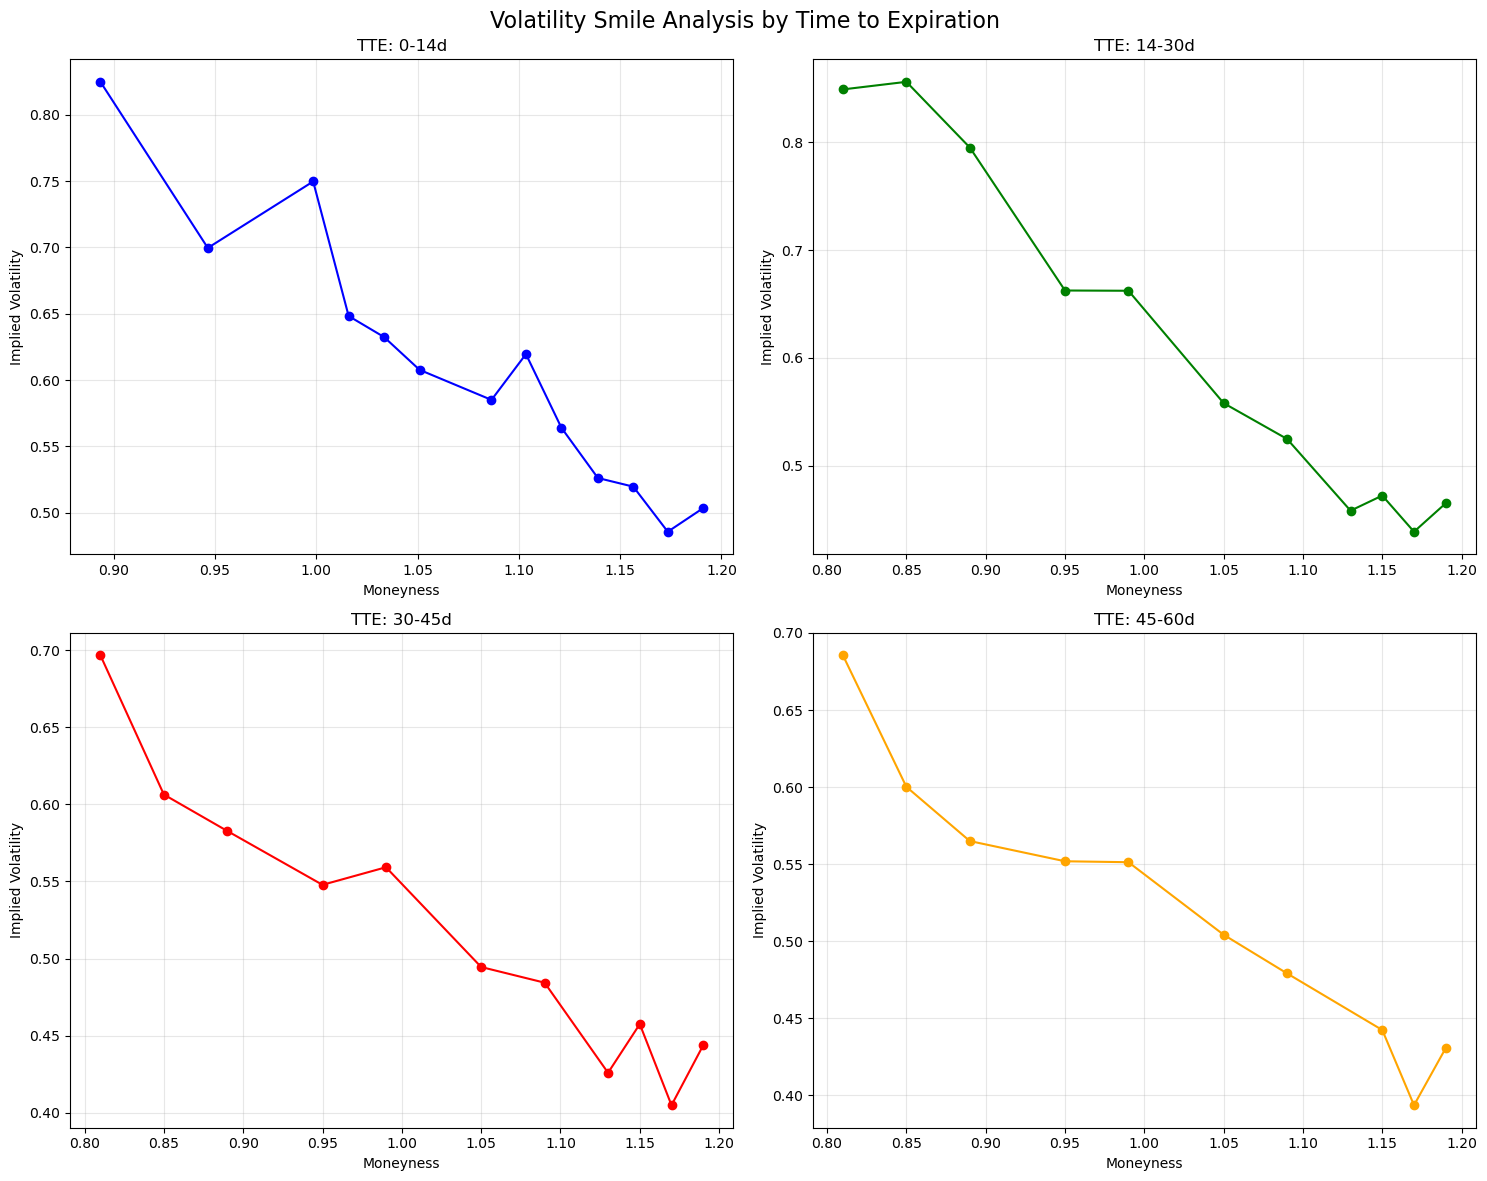


VOLATILITY SMILE ANALYSIS

Implied Volatility Statistics by TTE:
         count    mean     std     min     max
tte_bin                                       
0-14d      432  0.5591  0.1526  0.3325   1.709
14-30d     855  0.5284  0.1639  0.3505  1.6894
30-45d     643   0.487   0.089  0.3627  1.0404
45-60d     303  0.5022  0.1005  0.3566  1.2284

🔟 Running earnings event study...


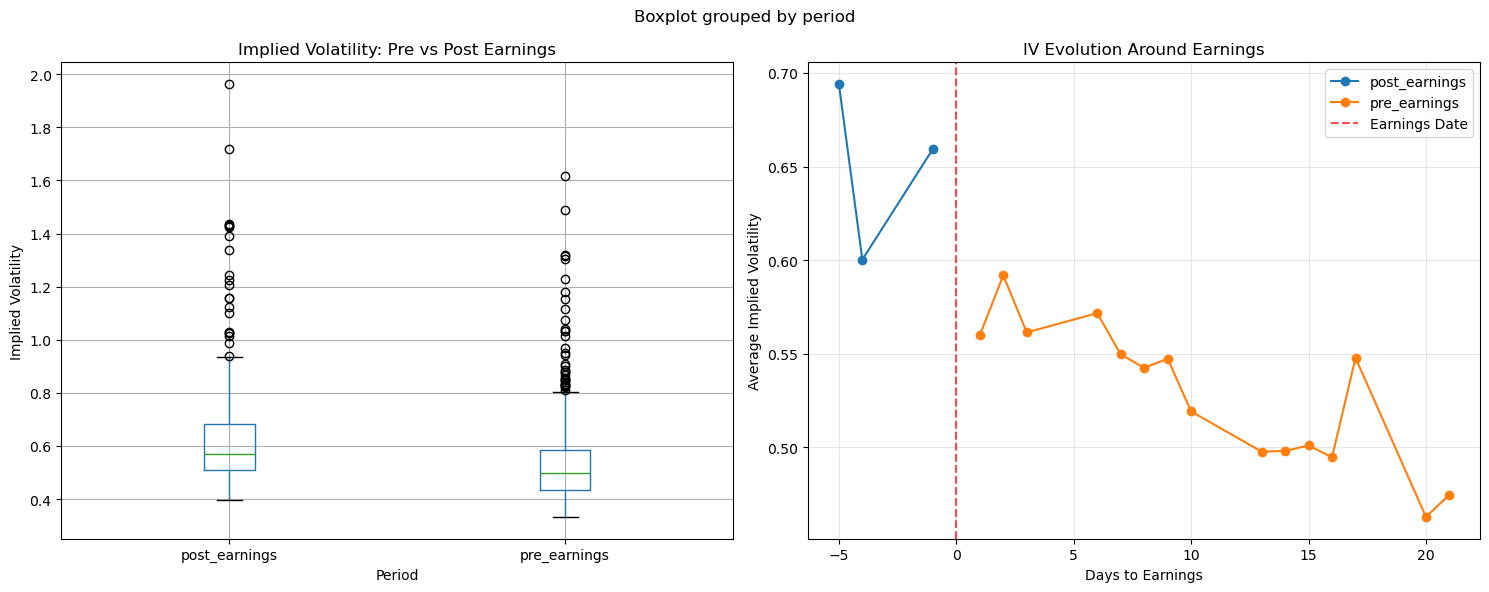


EARNINGS EVENT STUDY ANALYSIS
Pre-earnings IV: Mean = 0.5227, Std = 0.1275, N = 1326
Post-earnings IV: Mean = 0.6513, Std = 0.2468, N = 202
T-test: t-stat = -11.4424, p-value = 0.0000
*** Significant difference in pre vs post earnings IV ***

1️⃣1️⃣ Running term structure analysis...


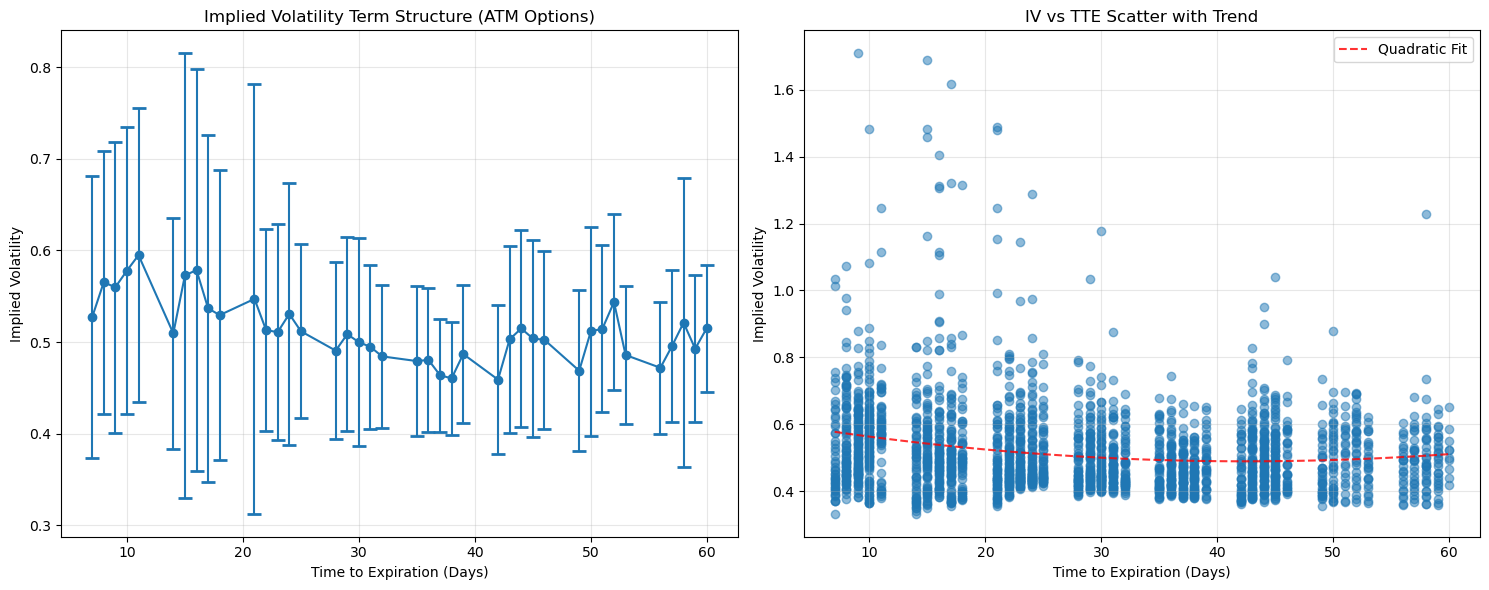


IMPLIED VOLATILITY TERM STRUCTURE

Term Structure Summary:
    tte    mean     std  count
0     7   0.527   0.154     47
1     8  0.5652  0.1433     82
2     9  0.5599  0.1588     94
3    10   0.578  0.1569    100
4    11  0.5949  0.1607     52
5    14  0.5095   0.126     57
6    15  0.5727  0.2425     74
7    16  0.5787  0.2197     79
8    17  0.5368  0.1896     79
9    18  0.5294  0.1583     49
10   21  0.5471  0.2345     69
11   22   0.513  0.1106     80
12   23  0.5108  0.1181     86
13   24  0.5307  0.1433     80
14   25  0.5118  0.0952     51
15   28  0.4907  0.0966     60
16   29  0.5086  0.1062     74
17   30  0.4999  0.1135     74
18   31  0.4947  0.0892     64
19   32  0.4844  0.0779     48
20   35  0.4792  0.0816     52
21   36  0.4805  0.0788     63
22   37  0.4637   0.062     64
23   38  0.4604   0.062     53
24   39  0.4869  0.0753     35
25   42   0.459  0.0815     41
26   43  0.5029  0.1022     75
27   44  0.5148  0.1074     76
28   45  0.5039  0.1078     72
29   46  0

In [2]:
# Main execution block
if __name__ == "__main__":
    """
    Example usage - modify as needed
    """
    
    import wrds
    
    # Connect to WRDS
    db = wrds.Connection(wrds_username='sami_sellami')
    
    # Define analysis parameters
    #TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA']
    TICKERS = ['AAPL']

    START_DATE = '2023-01-01'
    END_DATE = '2024-12-31'
    
    # Run analysis
    pipeline = run_earnings_iv_analysis(
        wrds_connection=db,
        tickers=TICKERS,
        start_date=START_DATE,
        end_date=END_DATE
    )
    
    # Access results
    if 'earnings_options' in pipeline.data:
        print(f"Final dataset shape: {pipeline.data['earnings_options'].shape}")
        print(f"Available columns: {list(pipeline.data['earnings_options'].columns)}")
    
    # Close connection
    db.close()
    
    print("Earnings IV Analysis Pipeline Loaded Successfully!")
    print("To use: create WRDS connection and call run_earnings_iv_analysis()")
